In [1]:
import sys
import os
import math
from pyspark.rdd import RDD
from pyspark import SparkConf, SparkContext
# os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jdk1.8.0_301'
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
conf = SparkConf().setMaster("local").setAppName("KMeans")
sc = SparkContext(conf=conf)

21/11/15 17:54:46 WARN Utils: Your hostname, yanlingkaideMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.114 instead (on interface en0)
21/11/15 17:54:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/15 17:54:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
c1 = sc.textFile("hw3-kmeans-testcase/c1.txt")
c2 = sc.textFile("hw3-kmeans-testcase/c2.txt")
data = sc.textFile("hw3-kmeans-testcase/data.txt")
test = sc.textFile("hw3-kmeans-testcase/test.txt")
data_test = sc.textFile("hw3-kmeans-testcase/data_test.txt")

iteration = 20

`txt` 中每一行代表一個點，每點有 58 個維度，因此利用 `mapper_split_point` 成功切割出每點

In [4]:
def mapper_split_point(c):
    point = c.split(" ")
    return point

`mapper_Euclidean_cost` 和 `mapper_Manhattan_cost` 分別用來計算 Euclidean cost 和 Manhattan cost。

其中， `(p, index), centroid = point` 是因為在前面我們有將 data `zipWithIndex`，來得知該筆 data 為第幾個點。

In [5]:
def mapper_Euclidean_cost(point):
    cost = 0
    (p, index), centroid = point
    for i in range(len(p)):
        cost = cost + (float(p[i]) - float(centroid[i]))**2
    return (tuple((tuple(p),index)), (centroid, cost))

In [6]:
def mapper_Manhattan_cost(point):
    cost = 0
    (p, index), centroid = point
    for i in range(len(p)):
        cost = cost + (abs(float(p[i]) - float(centroid[i])))
    return (tuple((tuple(p),index)), (centroid, cost))

In [7]:
# (c1, (p1, p2, ...)), (c2, (p3, p4, ...)) => [c1', c2', ...]
def mapper_new_centroid(centroid):
    new_centroid = []
    count = 1 
    for j in centroid[1]:
        for i in range(len(j)):
            if(count == 1):
                new_centroid.append(float(j[i])/len(centroid[1]))
            else:
                new_centroid[i]+=float(j[i])/len(centroid[1])
        count+=1
    return new_centroid

透過 `reduceByKey()`，我們將每點所有的 cost 集合在一起，再透過 `reducer_Min` 選出最適當的 centroid

In [8]:
def reducer_Min(x, y):
    # 比較 cost 大小， cost 小者回傳其 centroid
    if x[1] < y[1]:
        return x
    else:
        return y

In [9]:
# c1 切成 10 * 58 項， c1 為 list of list e.g. [['0'], ['0.64'], ...]
c1 = c1.map(mapper_split_point)
# c2 切成 10 * 58
c2 = c2.map(mapper_split_point)
# data 切成 4601 * 58, 且每一列和 index 形成 key-value pair, 方便 reduce
data = data.map(mapper_split_point).zipWithIndex()

# Euclidean distance

## Euclidean distance for c1

### Calculate cost of Euclidean for c1

In [10]:
cost_Euclidean_c1 = []
from operator import add
for i in range(iteration):
    allpair = data.cartesian(c1)
    Euclidean_cost = allpair.map(mapper_Euclidean_cost).reduceByKey(reducer_Min)
    c1 = Euclidean_cost.map(lambda x: (tuple(x[1][0]), tuple(x[0][0]))).groupByKey().map(mapper_new_centroid)
    
    cost_Euclidean_c1.append(Euclidean_cost.map(lambda x:(x[1][1])).reduce(add))
    

/Users/yenlingkai/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
  warnings.warn("Please install psutil to have better "
/Users/yenlingkai/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
  warnings.warn("Please install psutil to have better "
/Users/yenlingkai/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
  warnings.warn("Please install psutil to have better "


In [11]:
cost_Euclidean_c1

[623660345.3064234,
 509862908.29754597,
 485480681.87200826,
 463997011.6850107,
 460969266.572994,
 460537847.98277,
 460313099.6535423,
 460003523.88940674,
 459570539.3177352,
 459021103.34229004,
 458490656.19198066,
 457944232.5879741,
 457558005.19867957,
 457290136.35230315,
 457050555.0595638,
 456892235.61535734,
 456703630.73703563,
 456404203.01897687,
 456177800.5419951,
 455986871.0273484]

### Percentage improvement values

In [12]:
print(abs(cost_Euclidean_c1[iteration-1]-cost_Euclidean_c1[0])/cost_Euclidean_c1[0]*100)

26.885383292518288


### The Euclidean distance for all pairs of centroids (c1)

In [13]:
c1_Euc_dis = c1.collect()
result = []
for i in range(len(c1_Euc_dis)):
    dist = []
    for j in range(len(c1_Euc_dis)):
        distance = 0
        for k in range(len(c1_Euc_dis[i])):
            distance = distance + (c1_Euc_dis[i][k] - c1_Euc_dis[j][k])**2
        distance = round(distance**0.5, 3)
        dist.append(distance)
    result.append(dist)

from pandas import DataFrame
df = DataFrame(result)

df.to_csv("data/Euclidean_c1_Euclidean.csv")


In [14]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.000,646.931,1615.852,167.150,99.546,1038.827,346.719,220.902,142.439,3836.907
1,646.931,0.000,975.320,814.076,746.336,412.076,307.669,867.823,504.634,3195.924
2,1615.852,975.320,0.000,1782.203,1715.253,669.890,1282.771,1835.640,1474.945,2294.580
3,167.150,814.076,1782.203,0.000,67.912,1204.078,512.612,53.790,309.506,4002.689
4,99.546,746.336,1715.253,67.912,0.000,1136.327,444.731,121.634,241.730,3934.872
5,1038.827,412.076,669.890,1204.078,1136.327,0.000,692.158,1257.450,897.659,2798.801
6,346.719,307.669,1282.771,512.612,444.731,692.158,0.000,566.202,205.750,3490.259
7,220.902,867.823,1835.640,53.790,121.634,1257.450,566.202,0.000,363.263,4056.136
8,142.439,504.634,1474.945,309.506,241.730,897.659,205.750,363.263,0.000,3695.114
9,3836.907,3195.924,2294.580,4002.689,3934.872,2798.801,3490.259,4056.136,3695.114,0.000


### The Manhattan distance for all pairs of centroids (c1)

In [15]:
c1_Euc_dis = c1.collect()
result = []
for i in range(len(c1_Euc_dis)):
    dist = []
    for j in range(len(c1_Euc_dis)):
        distance = 0
        for k in range(len(c1_Euc_dis[i])):
            distance = distance + abs(c1_Euc_dis[i][k] - c1_Euc_dis[j][k])
        distance = round(distance, 3)
        dist.append(distance)
    result.append(dist)

from pandas import DataFrame
df = DataFrame(result)

df.to_csv("data/Euclidean_c1_Manhattan.csv")

In [16]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.000,779.397,2102.865,204.523,125.597,1100.833,374.890,272.935,171.365,4170.305
1,779.397,0.000,1327.584,983.020,904.370,490.928,406.701,1050.916,609.749,3396.420
2,2102.865,1327.584,0.000,2306.380,2227.556,1005.293,1731.064,2374.545,1934.087,2513.423
3,204.523,983.020,2306.380,0.000,79.402,1303.896,577.402,69.590,375.248,4372.789
4,125.597,904.370,2227.556,79.402,0.000,1225.352,499.158,147.866,296.255,4294.953
5,1100.833,490.928,1005.293,1303.896,1225.352,0.000,728.924,1372.092,935.885,3072.889
6,374.890,406.701,1731.064,577.402,499.158,728.924,0.000,645.770,212.181,3797.899
7,272.935,1050.916,2374.545,69.590,147.866,1372.092,645.770,0.000,443.498,4440.720
8,171.365,609.749,1934.087,375.248,296.255,935.885,212.181,443.498,0.000,4001.038
9,4170.305,3396.420,2513.423,4372.789,4294.953,3072.889,3797.899,4440.720,4001.038,0.000


## Euclidean distance for c2

### Calculate cost of Euclidean for c2

In [17]:
cost_Euclidean_c2 = []
from operator import add
for i in range(iteration):
    allpair = data.cartesian(c2)
    Euclidean_cost = allpair.map(mapper_Euclidean_cost).reduceByKey(reducer_Min)
    c2 = Euclidean_cost.map(lambda x: (tuple(x[1][0]), tuple(x[0][0]))).groupByKey().map(mapper_new_centroid)
    
    cost_Euclidean_c2.append(Euclidean_cost.map(lambda x:(x[1][1])).reduce(add))

In [18]:
cost_Euclidean_c2

[438747790.027918,
 249803933.62600282,
 194494814.4063139,
 169804841.45154336,
 156295748.80627602,
 149094208.10896608,
 142508531.61961603,
 132303869.40653005,
 117170969.83719078,
 108547377.17857014,
 102237203.31799622,
 98278015.74975733,
 95630226.12177442,
 93793314.05119286,
 92377131.96821104,
 91541606.25423908,
 91045573.83042423,
 90752240.10140836,
 90470170.18122776,
 90216416.17563143]

### Percentage improvement values

In [20]:
print(abs(cost_Euclidean_c2[iteration-1]-cost_Euclidean_c2[0])/cost_Euclidean_c2[0]*100)

79.437750291599


### The Euclidean distance for all pairs of centroids (c2)

In [21]:
c2_Euc_dis = c2.collect()
result_c2 = []
for i in range(len(c2_Euc_dis)):
    dist = []
    for j in range(len(c2_Euc_dis)):
        distance = 0
        for k in range(len(c2_Euc_dis[i])):
            distance = distance + (c2_Euc_dis[i][k] - c2_Euc_dis[j][k])**2
        distance = round(distance**0.5, 3)
        dist.append(distance)
    result_c2.append(dist)

from pandas import DataFrame
df_c2 = DataFrame(result_c2)

df_c2.to_csv('data/Euclidean_c2_Euclidean.csv')

/Users/yenlingkai/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
  warnings.warn("Please install psutil to have better "


In [22]:
df_c2

,0,1,2,3,4,5,6,7,8,9
0,0.000,1100.859,2105.443,402.891,3169.004,1924.624,9045.320,15760.122,14110.834,5567.685
1,1100.859,0.000,1010.198,698.488,2085.461,1182.864,7957.776,14682.451,13208.003,4492.458
2,2105.443,1010.198,0.000,1702.793,1080.535,1313.327,6947.821,13674.708,12508.957,3488.159
3,402.891,698.488,1702.793,0.000,2768.608,1615.788,8644.807,15362.418,13786.484,5169.937
4,3169.004,2085.461,1080.535,2768.608,0.000,2153.771,5876.330,12597.040,11938.376,2407.919
5,1924.624,1182.864,1313.327,1615.788,2153.771,0.000,7718.222,14455.119,12233.960,4404.563
6,9045.320,7957.776,6947.821,8644.807,5876.330,7718.222,0.000,6743.884,9545.879,3494.222
7,15760.122,14682.451,13674.708,15362.418,12597.040,14455.119,6743.884,0.000,11524.506,10192.525
8,14110.834,13208.003,12508.957,13786.484,11938.376,12233.960,9545.879,11524.506,0.000,10883.382
9,5567.685,4492.458,3488.159,5169.937,2407.919,4404.563,3494.222,10192.525,10883.382,0.000


### The Manhattan distance for all pairs of centroids (c2)

In [ ]:
c2_Euc_dis = c2.collect()
result_c2 = []
for i in range(len(c2_Euc_dis)):
    dist = []
    for j in range(len(c2_Euc_dis)):
        distance = 0
        for k in range(len(c2_Euc_dis[i])):
            distance = distance + abs(c2_Euc_dis[i][k] - c2_Euc_dis[j][k])
        distance = round(distance, 3)
        dist.append(distance)
    result_c2.append(dist)

from pandas import DataFrame
df_c2 = DataFrame(result_c2)

df_c2.to_csv('data/Euclidean_c2_Manhattan.csv')

In [ ]:
df_c2

## A plot of cost vs. iteration for 2 initialization strategies(c1 and c2)

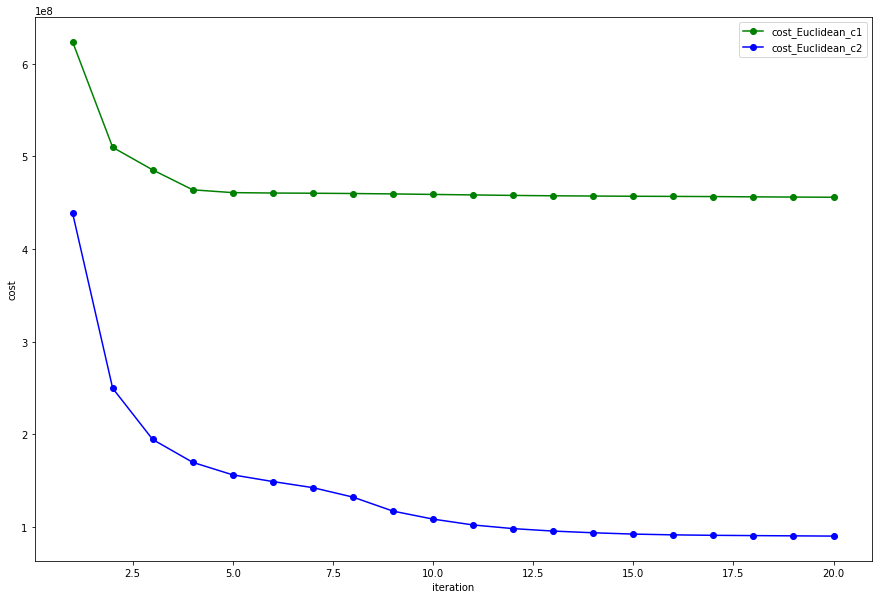

In [24]:
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
x = range(1,iteration+1)
plt.figure(figsize=(15,10),linewidth = 2)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.plot(x,cost_Euclidean_c1,'-o',color='green', label='cost_Euclidean_c1')
plt.plot(x,cost_Euclidean_c2,'-o',color='blue', label='cost_Euclidean_c2')
plt.legend(loc='upper right')

plt.show()

In [25]:
from pandas import DataFrame
row = ["round"+str(i) for i in range(1, iteration+1)]
data = list(zip(cost_Euclidean_c1, cost_Euclidean_c2))
df1 = DataFrame(data,columns=['c1', 'c2'], index=row)

In [26]:
df1

,c1,c2
round1,6.236603e+08,4.387478e+08
round2,5.098629e+08,2.498039e+08
round3,4.854807e+08,1.944948e+08
round4,4.639970e+08,1.698048e+08
round5,4.609693e+08,1.562957e+08
round6,4.605378e+08,1.490942e+08
round7,4.603131e+08,1.425085e+08
round8,4.600035e+08,1.323039e+08
round9,4.595705e+08,1.171710e+08
round10,4.590211e+08,1.085474e+08


# Manhattan distance

In [27]:
c1 = sc.textFile("hw3-kmeans-testcase/c1.txt")
c2 = sc.textFile("hw3-kmeans-testcase/c2.txt")
data = sc.textFile("hw3-kmeans-testcase/data.txt")

iteration = 20

# c1 切成 10 * 58 項， c1 為 list of list e.g. [['0'], ['0.64'], ...]
c1 = c1.map(mapper_split_point)
# c2 切成 10 * 58
c2 = c2.map(mapper_split_point)
# data 切成 4601 * 58, 且每一列和 index 形成 key-value pair, 方便 reduce
data = data.map(mapper_split_point).zipWithIndex()

## Manhattan distance for c1

### Calculate cost of Manhattan for c1

In [28]:
cost_Manhattan_c1 = []
from operator import add
for i in range(iteration):
    allpair = data.cartesian(c1)
    Manhattan_cost = allpair.map(mapper_Manhattan_cost).reduceByKey(reducer_Min)
    c1 = Manhattan_cost.map(lambda x: (tuple(x[1][0]), tuple(x[0][0]))).groupByKey().map(mapper_new_centroid)
    
    cost_Manhattan_c1.append(Manhattan_cost.map(lambda x:(x[1][1])).reduce(add))

/Users/yenlingkai/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
  warnings.warn("Please install psutil to have better "
/Users/yenlingkai/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
  warnings.warn("Please install psutil to have better "
/Users/yenlingkai/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
  warnings.warn("Please install psutil to have better "


In [29]:
cost_Manhattan_c1

[550117.1420000045,
 464661.07277264463,
 471200.04907668446,
 484160.6943550472,
 489251.7236234728,
 487564.74176785816,
 483404.05632034066,
 475365.3418409853,
 474924.05018140585,
 457233.6401358033,
 447495.09098985215,
 451004.3064630867,
 451222.0932561685,
 451973.8467044291,
 451585.35588920774,
 452756.645432641,
 452893.7923509914,
 450382.23409588065,
 450023.9688637897,
 448929.47449886805]

### Percentage improvement values

In [30]:
print(abs(cost_Manhattan_c1[iteration-1]-cost_Manhattan_c1[0])/cost_Manhattan_c1[0]*100)

18.393840107083165


### The Euclidean distance for all pairs of centroids (c1)

In [31]:
c1_Man_dis = c1.collect()
result = []
for i in range(len(c1_Man_dis)):
    dist = []
    for j in range(len(c1_Man_dis)):
        distance = 0
        for k in range(len(c1_Man_dis[i])):
            distance = distance + (c1_Man_dis[i][k] - c1_Man_dis[j][k])**2
        distance = round(distance**0.5, 3)
        dist.append(distance)
    result.append(dist)

from pandas import DataFrame
df = DataFrame(result)

df.to_csv("data/Manhattan_c1_Euclidean.csv")

### The Manhattan distance for all pairs of centroids (c1)

In [32]:
c1_Man_dis = c1.collect()
result = []
for i in range(len(c1_Man_dis)):
    dist = []
    for j in range(len(c1_Man_dis)):
        distance = 0
        for k in range(len(c1_Man_dis[i])):
            distance = distance + abs(c1_Man_dis[i][k] - c1_Man_dis[j][k])
        distance = round(distance, 3)
        dist.append(distance)
    result.append(dist)

from pandas import DataFrame
df = DataFrame(result)

df.to_csv("data/Manhattan_c1_Manhattan.csv")

## Manhattan distance for c2

### Calculate cost of Manhattan for c2

In [33]:
cost_Manhattan_c2 = []
from operator import add
for i in range(iteration):
    allpair = data.cartesian(c2)
    Manhattan_cost = allpair.map(mapper_Manhattan_cost).reduceByKey(reducer_Min)
    c2 = Manhattan_cost.map(lambda x: (tuple(x[1][0]), tuple(x[0][0]))).groupByKey().map(mapper_new_centroid)
    
    cost_Manhattan_c2.append(Manhattan_cost.map(lambda x:(x[1][1])).reduce(add))

### Percentage improvement values

In [34]:
print(abs(cost_Manhattan_c2[iteration-1]-cost_Manhattan_c2[0])/cost_Manhattan_c2[0]*100)

54.68569434813371


### The Euclidean distance for all pairs of centroids (c2)

In [35]:
c2_Man_dis = c2.collect()
result = []
for i in range(len(c2_Man_dis)):
    dist = []
    for j in range(len(c2_Man_dis)):
        distance = 0
        for k in range(len(c2_Man_dis[i])):
            distance = distance + (c2_Man_dis[i][k] - c2_Man_dis[j][k])**2
        distance = round(distance**0.5, 3)
        dist.append(distance)
    result.append(dist)

from pandas import DataFrame
df = DataFrame(result)

df.to_csv("data/Manhattan_c2_Euclidean.csv")

In [36]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.000,514.627,1571.243,1338.161,3022.661,2006.703,9032.333,15747.234,14100.145,5554.787
1,514.627,0.000,1081.379,827.841,2511.459,1637.729,8521.198,15239.877,13684.607,5047.516
2,1571.243,1081.379,0.000,566.551,1649.389,910.994,7588.405,14328.226,12643.986,4167.637
3,1338.161,827.841,566.551,0.000,1684.516,1405.109,7694.277,14412.057,13125.351,4219.761
4,3022.661,2511.459,1649.389,1684.516,0.000,2124.263,6009.820,12731.398,12006.395,2542.569
5,2006.703,1637.729,910.994,1405.109,2124.263,0.000,7742.628,14474.554,12167.794,4452.972
6,9032.333,8521.198,7588.405,7694.277,6009.820,7742.628,0.000,6743.884,9545.879,3494.222
7,15747.234,15239.877,14328.226,14412.057,12731.398,14474.554,6743.884,0.000,11524.506,10192.525
8,14100.145,13684.607,12643.986,13125.351,12006.395,12167.794,9545.879,11524.506,0.000,10883.382
9,5554.787,5047.516,4167.637,4219.761,2542.569,4452.972,3494.222,10192.525,10883.382,0.000


### The Manhattan distance for all pairs of centroids (c2)

In [37]:
c2_Man_dis = c2.collect()
result = []
for i in range(len(c2_Man_dis)):
    dist = []
    for j in range(len(c2_Man_dis)):
        distance = 0
        for k in range(len(c2_Man_dis[i])):
            distance = distance + abs(c2_Man_dis[i][k] - c2_Man_dis[j][k])
        distance = round(distance, 3)
        dist.append(distance)
    result.append(dist)

from pandas import DataFrame
df = DataFrame(result)

df.to_csv("data/Manhattan_c2_Manhattan.csv")

In [38]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.000,602.955,2102.554,1430.209,3211.456,3281.488,9517.668,15757.691,20200.259,5588.854
1,602.955,0.000,1500.825,833.430,2613.997,2682.569,8918.813,15335.957,19602.263,5123.067
2,2102.554,1500.825,0.000,674.828,2062.251,1358.796,7771.222,14980.056,18111.885,4768.923
3,1430.209,833.430,674.828,0.000,1784.512,1855.580,8090.510,14506.486,18775.121,4293.502
4,3211.456,2613.997,2062.251,1784.512,0.000,3413.036,6312.530,12922.931,16995.134,2710.057
5,3281.488,2682.569,1358.796,1855.580,3413.036,0.000,9116.025,16325.271,17521.518,6110.832
6,9517.668,8918.813,7771.222,8090.510,6312.530,9116.025,0.000,7219.197,10690.484,3935.293
7,15757.691,15335.957,14980.056,14506.486,12922.931,16325.271,7219.197,0.000,16003.499,10221.031
8,20200.259,19602.263,18111.885,18775.121,16995.134,17521.518,10690.484,16003.499,0.000,14613.552
9,5588.854,5123.067,4768.923,4293.502,2710.057,6110.832,3935.293,10221.031,14613.552,0.000


## A plot of cost vs. iteration for 2 initialization strategies(c1 and c2)

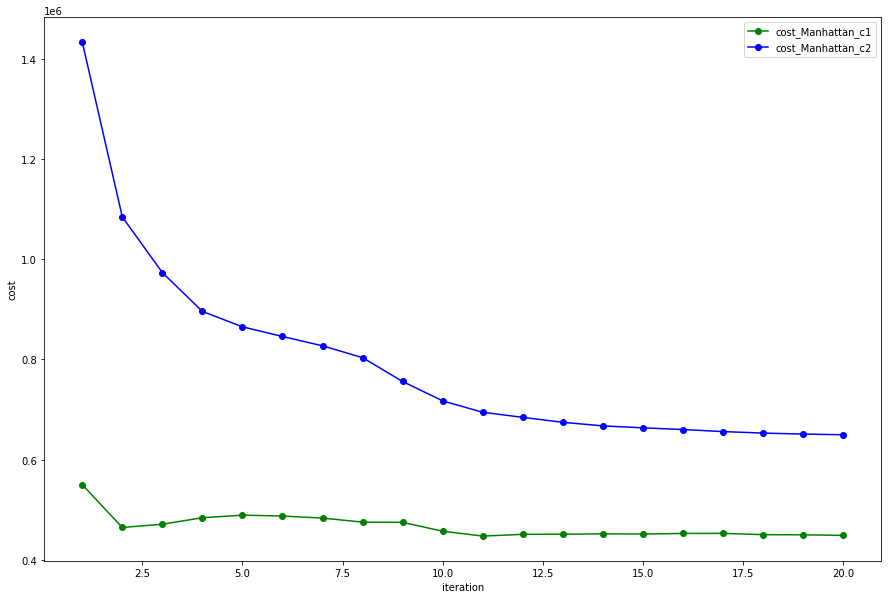

In [39]:
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
x = range(1,iteration+1)
plt.figure(figsize=(15,10),linewidth = 2)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.plot(x,cost_Manhattan_c1,'-o',color='green', label='cost_Manhattan_c1')
plt.plot(x,cost_Manhattan_c2,'-o',color='blue', label='cost_Manhattan_c2')
plt.legend(loc='upper right')

plt.show()

In [40]:
from pandas import DataFrame
row = ["round"+str(i) for i in range(1, iteration+1)]
data = list(zip(cost_Manhattan_c1, cost_Manhattan_c2))
df1 = DataFrame(data,columns=['c1', 'c2'], index=row)

In [41]:
df1

,c1,c2
round1,550117.142000,1.433739e+06
round2,464661.072773,1.084489e+06
round3,471200.049077,9.734317e+05
round4,484160.694355,8.959346e+05
round5,489251.723623,8.651283e+05
round6,487564.741768,8.458466e+05
round7,483404.056320,8.272196e+05
round8,475365.341841,8.035903e+05
round9,474924.050181,7.560395e+05
round10,457233.640136,7.173329e+05


In [42]:
sc.stop()